# Machine Learning with Parallel Processing using Dask

## Project Overview
This project demonstrates performance improvements using Dask for parallel processing in a machine learning workflow, specifically for predicting machine failures using a Random Forest Classifier.

**Code Execution procedure:**

## Prerequisites
- Python 3.8+
- Pip or Conda package manager

## Setup and Installation

1. Clone the repository:
```bash
git clone https://github.com/abhii2003/pridictive-maintenance-using-HPC.git
cd pridictive-maintenance-using-HPC
```

2. Create a virtual environment:
```bash
python -m venv .venv
source .venv/bin/activate  # On Windows: .venv\Scripts\activate
```

3. Install required dependencies:
```bash
pip install pandas dask distributed scikit-learn dask-ml
```

## Dataset
- The project uses `ai4i2020.csv` for machine failure prediction
- Ensure the CSV file is in the same directory as the notebook

## Running the Notebook
```bash
jupyter notebook PC_iot.ipynb
```



In [34]:
#  Import Libraries and Setup
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import ParallelPostFit
from sklearn.ensemble import RandomForestClassifier
from dask.diagnostics import ProgressBar
import time
from tabulate import tabulate
from sklearn.metrics import classification_report

In [35]:
#  Start Dask Client
cluster = LocalCluster(n_workers=5, threads_per_worker=2)
client = Client(cluster)
print(f"Dask dashboard available at: {client.dashboard_link}")

#  Load CSV Data
file_path = "ai4i2020.csv"
df = pd.read_csv(file_path)

#  Drop unnecessary columns & rename for simplicity
df.drop(columns=["UDI", "Product ID"], inplace=True)
df.rename(columns={
    "Air temperature [K]": "air_temp",
    "Process temperature [K]": "process_temp",
    "Rotational speed [rpm]": "rpm",
    "Torque [Nm]": "torque",
    "Tool wear [min]": "tool_wear",
    "Machine failure": "failure_risk"
}, inplace=True)

Dask dashboard available at: http://127.0.0.1:8787/status


In [36]:
#  Convert to Dask DataFrame
ddf = dd.from_pandas(df, npartitions=12)

#  Preprocess Data Function
def preprocess_data(df):
    df["temp_diff"] = df["process_temp"] - df["air_temp"]
    df["torque_rpm_ratio"] = df["torque"] / df["rpm"]
    return df

#  Non-Dask Preprocessing
start_time = time.time()
df_processed = preprocess_data(df)
non_dask_time = time.time() - start_time
print(f"Non-Dask Preprocessing Time: {non_dask_time:.3f} seconds")

#  Dask Preprocessing
start_time = time.time()
ddf_processed = ddf.map_partitions(preprocess_data).persist()
dask_time = time.time() - start_time
print(f"Dask Preprocessing Time: {dask_time:.3f} seconds")

Non-Dask Preprocessing Time: 0.002 seconds
Dask Preprocessing Time: 0.030 seconds


In [37]:
#  Feature Selection
features = ["air_temp", "process_temp", "rpm", "torque", "tool_wear", "temp_diff", "torque_rpm_ratio"]
target = "failure_risk"

#  Non-Dask Scaling
start_time = time.time()
X_non_dask = df_processed[features]
y_non_dask = df_processed[target]
X_scaled_non_dask = StandardScaler().fit_transform(X_non_dask)
non_dask_scaling_time = time.time() - start_time
print(f"Non-Dask Scaling Time: {non_dask_scaling_time:.3f} seconds")

#  Dask Scaling
start_time = time.time()
X_dask = ddf_processed[features]
y_dask = ddf_processed[target]
X_scaled_dask = StandardScaler().fit_transform(X_dask).persist()
dask_scaling_time = time.time() - start_time
print(f"Dask Scaling Time: {dask_scaling_time:.3f} seconds")

c:\Users\91936\Desktop\PC\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\91936\Desktop\PC\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


Non-Dask Scaling Time: 0.934 seconds
Dask Scaling Time: 0.103 seconds


c:\Users\91936\Desktop\PC\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\91936\Desktop\PC\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(


In [38]:

#  Train-Test Split
X_train_non_dask, X_test_non_dask, y_train_non_dask, y_test_non_dask = train_test_split(
    X_scaled_non_dask, y_non_dask, test_size=0.2, random_state=42, shuffle=True
)
X_train_dask, X_test_dask, y_train_dask, y_test_dask = train_test_split(
    X_scaled_dask, y_dask, test_size=0.2, random_state=42, shuffle=True
)

#  Model Setup
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model = ParallelPostFit(estimator=rfd)

In [39]:
#  Non-Dask Model Training
start_time = time.time()
model.fit(X_train_non_dask, y_train_non_dask)
non_dask_training_time = time.time() - start_time
print(f"Non-Dask Model Training Time: {non_dask_training_time:.3f} seconds")

#  Dask Model Training
start_time = time.time()
with ProgressBar():
    model.fit(X_train_dask.compute(), y_train_dask.compute())  
dask_training_time = time.time() - start_time
print(f"Dask Model Training Time: {dask_training_time:.3f} seconds")

#  Model Predictions
start_time = time.time()
y_pred_non_dask = model.predict(X_test_non_dask)
non_dask_prediction_time = time.time() - start_time
print(f"Non-Dask Prediction Time: {non_dask_prediction_time:.3f} seconds")
start_time = time.time()
y_pred_dask = model.predict(X_test_dask.compute())
dask_prediction_time = time.time() - start_time
print(f"Dask Prediction Time: {dask_prediction_time:.3f} seconds")

Non-Dask Model Training Time: 0.238 seconds
Dask Model Training Time: 0.406 seconds
Non-Dask Prediction Time: 0.043 seconds
Dask Prediction Time: 0.151 seconds


In [40]:


#  Compute Total Execution Times
total_no_dask_time = non_dask_time + non_dask_scaling_time + non_dask_training_time + non_dask_prediction_time
total_dask_time = dask_time + dask_scaling_time + dask_training_time + dask_prediction_time

#  Print Execution Times Table
table = [
    ["Stage", "Non-Dask Time (s)", "Dask Time (s)"],
    ["Preprocessing", f"{non_dask_time:.3f}", f"{dask_time:.3f}"],
    ["Scaling", f"{non_dask_scaling_time:.3f}", f"{dask_scaling_time:.3f}"],
    ["Training", f"{non_dask_training_time:.3f}", f"{dask_training_time:.3f}"],
    ["Prediction", f"{non_dask_prediction_time:.3f}", f"{dask_prediction_time:.3f}"],
    ["Total", f"{total_no_dask_time:.3f}", f"{total_dask_time:.3f}"],
]

print("\n=== Execution Time Comparison ===")
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

#  Model Evaluation
print("\n=== Non-Dask Classification Report ===")
print(classification_report(y_test_non_dask, y_pred_non_dask))

print("\n=== Dask Classification Report ===")
print(classification_report(y_test_dask.compute(), y_pred_dask))


=== Execution Time Comparison ===
+---------------+-------------------+---------------+
|     Stage     | Non-Dask Time (s) | Dask Time (s) |
+---------------+-------------------+---------------+
| Preprocessing |       0.002       |     0.030     |
|    Scaling    |       0.934       |     0.103     |
|   Training    |       0.238       |     0.406     |
|  Prediction   |       0.043       |     0.151     |
|     Total     |       1.216       |     0.689     |
+---------------+-------------------+---------------+

=== Non-Dask Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1939
           1       0.98      0.82      0.89        61

    accuracy                           0.99      2000
   macro avg       0.99      0.91      0.94      2000
weighted avg       0.99      0.99      0.99      2000


=== Dask Classification Report ===
              precision    recall  f1-score   support

           0       0.

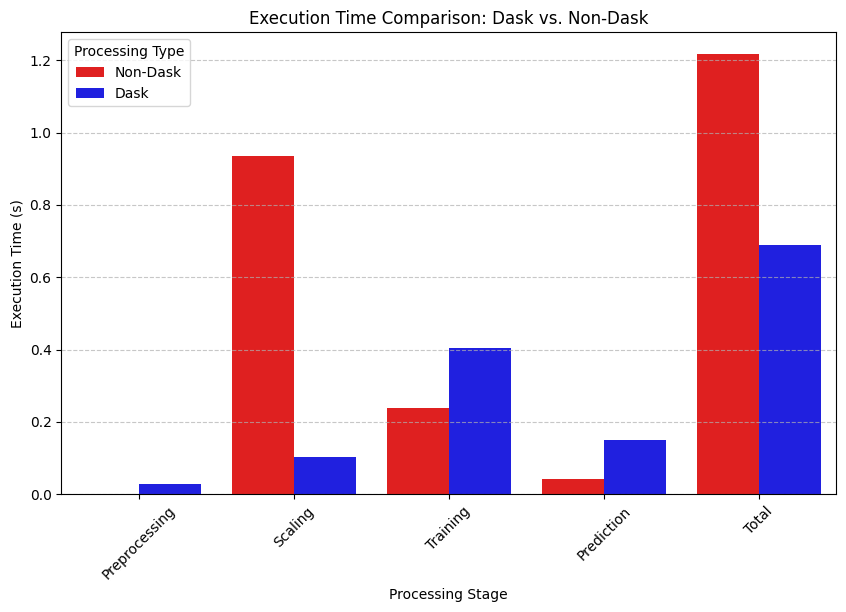

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Data for Visualization
stages = ["Preprocessing", "Scaling", "Training", "Prediction", "Total"]
non_dask_times = [non_dask_time, non_dask_scaling_time, non_dask_training_time, non_dask_prediction_time, total_no_dask_time]
dask_times = [dask_time, dask_scaling_time, dask_training_time, dask_prediction_time, total_dask_time]

#  Create a DataFrame
df_viz = pd.DataFrame({"Stage": stages, "Non-Dask": non_dask_times, "Dask": dask_times})

#  Plot Setup
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz.melt(id_vars="Stage"), x="Stage", y="value", hue="variable", palette=["red", "blue"])
plt.xlabel("Processing Stage")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time Comparison: Dask vs. Non-Dask")
plt.legend(title="Processing Type")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

#  Show Plot
plt.show()


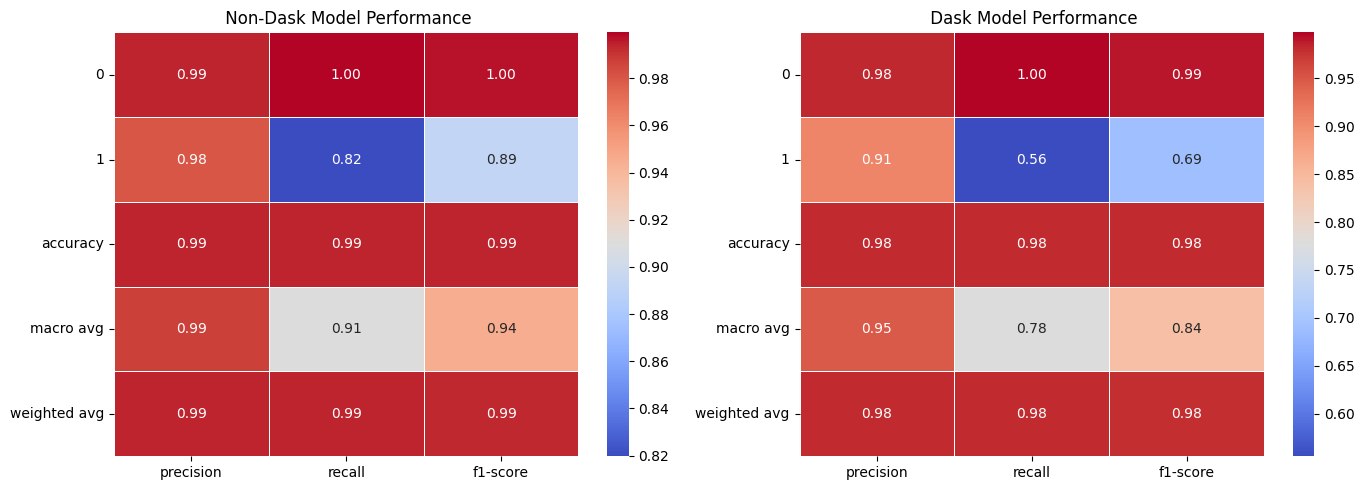

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

#  Generate Classification Reports as Dictionaries
report_non_dask = classification_report(y_test_non_dask, y_pred_non_dask, output_dict=True)
report_dask = classification_report(y_test_dask.compute(), y_pred_dask, output_dict=True)

#  Convert to DataFrame
df_non_dask = pd.DataFrame(report_non_dask).transpose()
df_dask = pd.DataFrame(report_dask).transpose()

#  Remove support column (not relevant for visualization)
df_non_dask.drop(columns=["support"], inplace=True)
df_dask.drop(columns=["support"], inplace=True)

#  Setup Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#  Heatmap for Non-Dask Model
sns.heatmap(df_non_dask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title(" Non-Dask Model Performance")

#  Heatmap for Dask Model
sns.heatmap(df_dask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title(" Dask Model Performance")

#  Show Plot
plt.tight_layout()
plt.show()


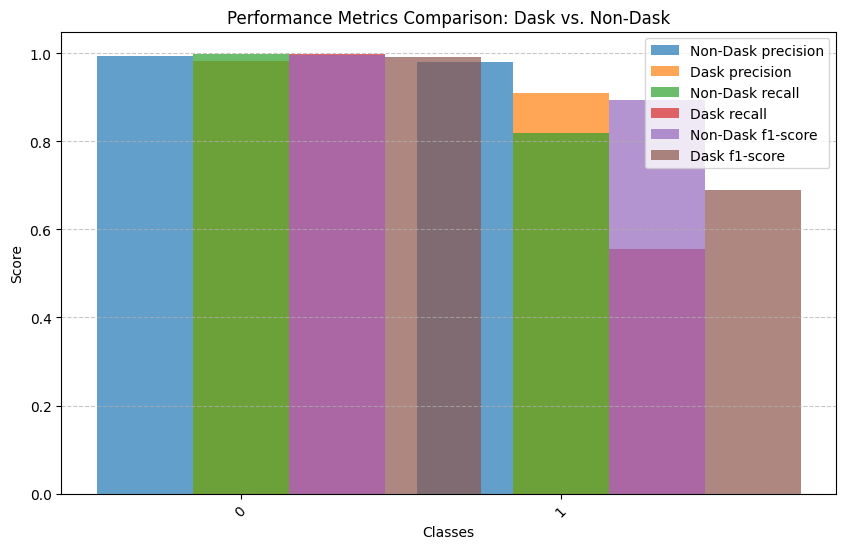

In [43]:
#  Extract Key Metrics
metrics = ["precision", "recall", "f1-score"]
classes = list(report_non_dask.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

#  Extract values
non_dask_values = [[report_non_dask[cls][metric] for metric in metrics] for cls in classes]
dask_values = [[report_dask[cls][metric] for metric in metrics] for cls in classes]

#  Convert to NumPy Array
non_dask_values = np.array(non_dask_values)
dask_values = np.array(dask_values)

#  Create Bar Chart
x = np.arange(len(classes))  
width = 0.3  

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + (i - 1) * width, non_dask_values[:, i], width, label=f"Non-Dask {metric}", alpha=0.7)
    ax.bar(x + (i - 1) * width + width, dask_values[:, i], width, label=f"Dask {metric}", alpha=0.7)

#  Labeling
ax.set_xlabel("Classes")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics Comparison: Dask vs. Non-Dask")
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show Plot
plt.show()


In [44]:
client.close()
cluster.close()

After running the same program under different conditions : --

when the processor is not heavily loaded(with acuuracy of the model remaining the same ):

The total time without parallel processing :  1.7222778797149658
The total time with parallel processing :  1.1148769855499268

The total time without parallel processing :  1.766350269317627
The total time with parallel processing :  1.2246372699737549

The total time without parallel processing :  1.6738755702972412
The total time with parallel processing :  1.071552038192749

The total time without parallel processing :  1.6822710037231445
The total time with parallel processing :  1.0445265769958496

The total time without parallel processing :  1.6538524627685547
The total time with parallel processing :  1.0917551517486572

The total time without parallel processing :  1.6362357139587402
The total time with parallel processing :  1.077573299407959

When the processor is heavily loaded (using heavy calculation programs such as finding the fibonacci and factorial and opening multiple chrome tabs playing video) : --

The total time without parallel processing: 138.758 seconds
The total time with parallel processing: 80.106 seconds

The total time without parallel processing :  140.77893042564392
The total time with parallel processing :  37.52039980888367